In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [4]:
data, info = tfds.load('tf_flowers', with_info=True)
print(data, info)
data.keys()

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>} tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\euiso\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    ur

dict_keys(['train'])

In [5]:
ds_train = data['train']
print(len(ds_train))

3670


In [6]:
print(len(ds_train))

ds_train = ds_train.map(lambda x:(tf.image.resize(x['image'], (150, 150)), x['label']))
ds_train = ds_train.shuffle(1000).batch(3670)
batch = next(iter(ds_train))
print(batch[0].shape, type(batch[0]), batch[1].shape, type(batch[1]))

3670
(3670, 150, 150, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
images, labels = batch
print(images.shape, type(images), labels.shape, type(labels))

(3670, 150, 150, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
# 만든 데이터를 확인하기 위해 그림을 그려보면

import matplotlib.pyplot as plt

label_map = {
    0 : 'dandelion',
    1 : 'daisy',
    2 : 'tulip',
    3 : 'sunflower',
    4 : 'rose'
}

images = images.numpy() / 255
labels = labels.numpy()

print(images.shape, type(images), labels.shape, type(labels))

(3670, 150, 150, 3) <class 'numpy.ndarray'> (3670,) <class 'numpy.ndarray'>


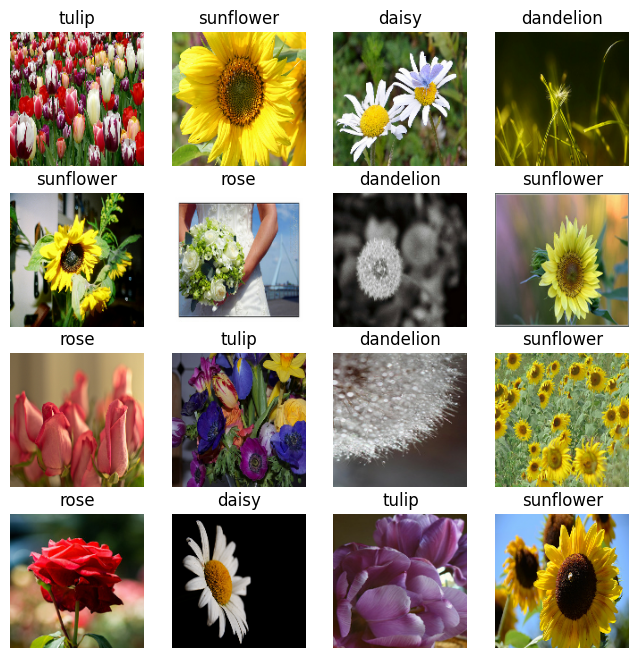

In [9]:
import random
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [10]:
# # 이미지 크기를 조정하고 numpy 배열로 변환
# def preprocess_data(dataset):
#     images = []
#     labels = []
#     for example in dataset:
#         image = example['image'].numpy() / 255.0  # 이미지 정규화
#         label = example['label'].numpy()
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# train_images, train_labels = preprocess_data(ds_train)

# print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))


In [11]:
# train, test 로 나누기 위해서 슬라이싱

train_images = images[:-600]
train_labels = labels[:-600]
test_images = images[-600 :]
test_labels = labels[-600 :]

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

(3070, 150, 150, 3) <class 'numpy.ndarray'> (3070,) <class 'numpy.ndarray'>
(600, 150, 150, 3) <class 'numpy.ndarray'> (600,) <class 'numpy.ndarray'>


In [12]:
# torch tensor로 바꾸고, 모양도 (150, 150, 3) (3, 150, 150) 으로 바꾼다

import torch
train_images = torch.tensor(train_images).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images).permute(0, 3, 1, 2)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

torch.Size([3070, 3, 150, 150]) <class 'torch.Tensor'> torch.Size([3070]) <class 'torch.Tensor'>
torch.Size([600, 3, 150, 150]) <class 'torch.Tensor'> torch.Size([600]) <class 'torch.Tensor'>


In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# CustomDataset 인스턴스 생성
train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)

In [14]:
# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader 데이터 확인
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, {type(X)}, {y.dtype}")
    print(f"Shape of y: {y.shape}, {type(y)}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 150, 150]), <class 'torch.Tensor'>, torch.int64
Shape of y: torch.Size([64]), <class 'torch.Tensor'>, torch.int64


In [15]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*150*150, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=67500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-6)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).float(), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 3 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.612309  [   64/ 3070]
loss: 1.603865  [  256/ 3070]
loss: 1.608611  [  448/ 3070]
loss: 1.617595  [  640/ 3070]
loss: 1.612429  [  832/ 3070]
loss: 1.607387  [ 1024/ 3070]
loss: 1.618562  [ 1216/ 3070]
loss: 1.616683  [ 1408/ 3070]
loss: 1.612535  [ 1600/ 3070]
loss: 1.609928  [ 1792/ 3070]
loss: 1.613611  [ 1984/ 3070]
loss: 1.608744  [ 2176/ 3070]
loss: 1.613420  [ 2368/ 3070]
loss: 1.615529  [ 2560/ 3070]
loss: 1.611232  [ 2752/ 3070]
loss: 1.612122  [ 2944/ 3070]
Test Error: 
 Accuracy: 21.7%, Avg loss: 1.609077 

Epoch 2
-------------------------------
loss: 1.610193  [   64/ 3070]
loss: 1.612514  [  256/ 3070]
loss: 1.610189  [  448/ 3070]
loss: 1.610850  [  640/ 3070]
loss: 1.606375  [  832/ 3070]
loss: 1.609120  [ 1024/ 3070]
loss: 1.610000  [ 1216/ 3070]
loss: 1.614870  [ 1408/ 3070]
loss: 1.617940  [ 1600/ 3070]
loss: 1.609959  [ 1792/ 3070]
loss: 1.607976  [ 1984/ 3070]
loss: 1.607960  [ 2176/ 3070]
loss: 1.607494  [ 2368/ 3070

In [20]:
import torch
import torchvision.models as models

# RegNet 모델 가져오기
model = models.regnet_y_400mf(pretrained=True)

# 모델 요약 정보 출력 (PyTorch에서는 summary 기능을 제공하지 않으므로 모델 구조를 출력)
print(model)


c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to C:\Users\euiso/.cache\torch\hub\checkpoints\regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:01<00:00, 11.3MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [21]:
import torch.nn as nn

# 출력 클래스 수
num_classes = 10  # 예를 들어 CIFAR-10 데이터셋

# 마지막 레이어 수정
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 모델 학습 준비
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/30, Loss: 0.5220131274933616
Epoch 2/30, Loss: 0.17232398743120333
Epoch 3/30, Loss: 0.1127935490027691
Epoch 4/30, Loss: 0.08807966074285407
Epoch 5/30, Loss: 0.08715862132764111
Epoch 6/30, Loss: 0.1008209209345902
Epoch 7/30, Loss: 0.06585335013611864
